### 目前最优方案

解经验证：所有约束均满足，解可行。
最终总距离：2262.4118564703326
车1: 0 -> 153 -> 136 -> 3 -> 43 -> 124 -> 180 -> 48 -> 131 -> 24 -> 156 -> 102 -> 152 -> 169 -> 61 -> 198 -> 167 -> 190 -> 184 -> 196 -> 183 -> 15 -> 179 -> 7 -> 18 -> 68 -> 116 -> 95 -> 83 -> 148 -> 36 -> 0
车2: 0 -> 150 -> 187 -> 163 -> 28 -> 6 -> 49 -> 14 -> 47 -> 200 -> 103 -> 90 -> 44 -> 145 -> 111 -> 91 -> 51 -> 27 -> 126 -> 80 -> 110 -> 178 -> 39 -> 0
车3: 0 -> 177 -> 65 -> 128 -> 168 -> 99 -> 94 -> 151 -> 112 -> 56 -> 45 -> 108 -> 38 -> 32 -> 74 -> 52 -> 31 -> 23 -> 117 -> 114 -> 86 -> 85 -> 165 -> 125 -> 189 -> 109 -> 160 -> 53 -> 101 -> 192 -> 50 -> 157 -> 33 -> 0
车4: 0 -> 155 -> 88 -> 69 -> 176 -> 113 -> 191 -> 58 -> 134 -> 84 -> 199 -> 127 -> 105 -> 118 -> 137 -> 123 -> 71 -> 11 -> 144 -> 115 -> 121 -> 87 -> 17 -> 174 -> 97 -> 13 -> 75 -> 8 -> 60 -> 1 -> 175 -> 30 -> 64 -> 0
车5: 0 -> 130 -> 171 -> 132 -> 78 -> 162 -> 63 -> 149 -> 170 -> 10 -> 25 -> 104 -> 164 -> 35 -> 77 -> 122 -> 181 -> 62 -> 5 -> 197 -> 42 -> 172 -> 138 -> 46 -> 159

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31751 (\N{CJK UNIFIED IDEOGRAPH-7C07}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python312\

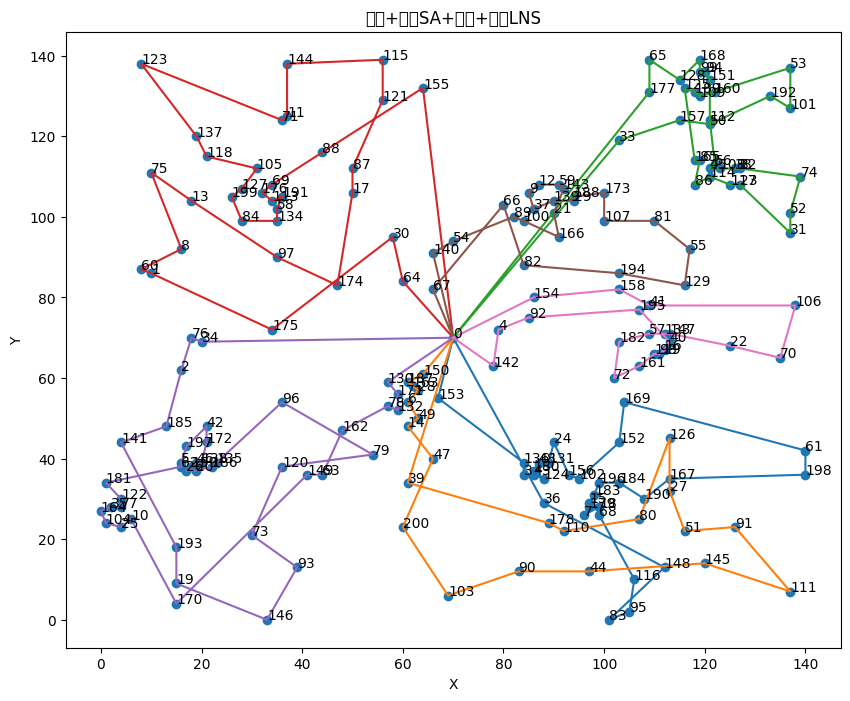

In [30]:
import pandas as pd
import numpy as np
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ------ 参数配置 ------
EXCEL_PATH = r"C:\Users\Administrator\Desktop\RC2_2_10.xlsx"
CAPACITY = 1000
GLOBAL_TIME_LIMIT = 180  # 秒
CLUSTER_COUNT = 5
# SA 参数
SA_INITIAL_TEMP = 1000
SA_INTERVAL = 500
SA_THRESHOLD = 0.1
# 2-opt 限制尝试
TWO_OPT_TRIALS = 300
# LNS 参数
LNS_REMOVE_COUNT = 5
# 全局 LNS 时间比例
GLOBAL_LNS_RATIO = 0.2

# ------ 数据读取 ------
df = pd.read_excel(EXCEL_PATH)
nodes = df['id'].tolist()
coords = df[['x_coord', 'y_coord']].values
demand = dict(zip(nodes, df['demand']))
ready = dict(zip(nodes, df['et']))
due   = dict(zip(nodes, df['lt']))
service = dict(zip(nodes, df['st']))

# ------ 聚类划分 ------
non_depot = nodes[1:]
non_coords = coords[1:]
km = KMeans(n_clusters=CLUSTER_COUNT, random_state=0).fit(non_coords)
clusters = {i: [] for i in range(CLUSTER_COUNT)}
for node, lab in zip(non_depot, km.labels_):
    clusters[lab].append(node)

# ------ 子问题构建 ------
def build_problem(sub_nodes):
    sub = [nodes[0]] + sub_nodes
    sub_coords = np.array([coords[nodes.index(n)] for n in sub])
    m = len(sub)
    d = np.zeros((m, m))
    for i in range(m):
        for j in range(m): d[i,j] = math.hypot(*(sub_coords[i]-sub_coords[j]))
    sd = {n: demand[n] for n in sub}
    sr = {n: ready[n] for n in sub}
    sl = {n: due[n] for n in sub}
    ss = {n: service[n] for n in sub}
    return sub, d, sd, sr, sl, ss

# ------ 成本计算 ------
def cost_route(route, sub, d, sd, sr, sl, ss):
    c,t,load=0,0,0; prev=0
    for n in route:
        i=sub.index(n)
        c+=d[prev,i]
        t=max(t+d[prev,i], sr[n])+ss[n]
        if t>sl[n] or load+sd[n]>CAPACITY: return float('inf'), None
        load+=sd[n]; prev=i
    c+=d[prev,0]
    return c,t

def cost_total(sol, sub, d, sd, sr, sl, ss):
    return sum(cost_route(r,sub,d,sd,sr,sl,ss)[0] for r in sol)

# ------ 初始化 & 本地搜索 & LNS ------
def greedy_init(sub, d, sd, sr, sl, ss):
    un=set(sub[1:]); sol=[]
    while un:
        route,load,t,prev=[],0,0,0
        for n in sorted(un, key=lambda x: sr[x]):
            if load+sd[n]<=CAPACITY:
                i=sub.index(n); arr=max(t+d[prev,i], sr[n])
                if arr+ss[n]<=sl[n]: route.append(n); load+=sd[n]; t=arr+ss[n]; prev=i
        sol.append(route); un-=set(route)
    return sol

def limited_two_opt(route, sub, d, sd, sr, sl, ss, tb):
    st=time.time(); best=route[:]; bc=cost_route(best,sub,d,sd,sr,sl,ss)[0]
    for _ in range(TWO_OPT_TRIALS):
        if time.time()-st>tb: break
        i,j=sorted(random.sample(range(1,len(best)),2));
        if j-i<2: continue
        cand=best[:]; cand[i:j]=reversed(cand[i:j])
        cc=cost_route(cand,sub,d,sd,sr,sl,ss)[0]
        if cc<bc: best,bc=cand,cc
    return best

def lns(sol, sub, d, sd, sr, sl, ss, tb):
    st=time.time(); best=sol; bc=cost_total(sol,sub,d,sd,sr,sl,ss)
    while time.time()-st<tb:
        ns=[r[:] for r in best]; rem=[]
        for _ in range(LNS_REMOVE_COUNT):
            ri=random.randrange(len(ns));
            if ns[ri]: rem.append(ns[ri].pop(random.randrange(len(ns[ri]))))
        for n in rem:
            best_ins=(None,None,math.inf)
            for ri in range(len(ns)):
                for pos in range(len(ns[ri])+1):
                    tmp=ns[ri][:]; tmp.insert(pos,n)
                    c=cost_route(tmp,sub,d,sd,sr,sl,ss)[0]
                    if c<best_ins[2]: best_ins=(ri,pos,c)
            if best_ins[0] is None: ns.append([n])
            else: ns[best_ins[0]].insert(best_ins[1],n)
        nc=cost_total(ns,sub,d,sd,sr,sl,ss)
        if nc<bc: best,bc=ns,nc
    return best,bc

def solve_subproblem(sub_nodes, time_limit):
    sub,d,sd,sr,sl,ss=build_problem(sub_nodes)
    sol=greedy_init(sub,d,sd,sr,sl,ss)
    best,bc, curr,cc=sol,cost_total(sol,sub,d,sd,sr,sl,ss),sol,cost_total(sol,sub,d,sd,sr,sl,ss)
    T0=SA_INITIAL_TEMP; st=time.time(); it=0
    sa_time=time_limit*(1-GLOBAL_LNS_RATIO)
    while time.time()-st<sa_time:
        T=T0*(1-(time.time()-st)/sa_time)
        ns=[r[:] for r in curr]
        if len(ns)>1:
            r1,r2=random.sample(range(len(ns)),2)
            if ns[r1]:
                n=ns[r1].pop(random.randrange(len(ns[r1])));
                ns[r2].insert(random.randrange(len(ns[r2])+1),n)
                ns=[r for r in ns if r]
                nc=cost_total(ns,sub,d,sd,sr,sl,ss); delta=nc-cc
                if delta<0 or random.random()<math.exp(-delta/max(T,1e-8)):
                    curr,cc=ns,nc
                    if cc<bc:
                        best,bc=[r[:] for r in curr],cc
                        rem=sa_time-(time.time()-st)
                        if it%SA_INTERVAL==0 and T<T0*SA_THRESHOLD and rem>1:
                            wi=max(range(len(curr)),key=lambda i:cost_route(curr[i],sub,d,sd,sr,sl,ss)[0])
                            curr[wi]=limited_two_opt(curr[wi],sub,d,sd,sr,sl,ss,rem*0.5)
                            cc=cost_total(curr,sub,d,sd,sr,sl,ss)
                            if cc<bc: best,bc=[r[:] for r in curr],cc
        it+=1
    # 全局 LNS 强化
    remaining= time_limit - (time.time()-st)
    if remaining>1: best,bc=lns(best,sub,d,sd,sr,sl,ss,remaining)
    return best,bc

def validate_solution(routes):
    visited = set()
    feasible = True
    for idx, route in enumerate(routes, 1):
        load = 0; t = 0; prev = nodes[0]
        for n in route:
            if n in visited:
                print(f"节点 {n} 在车辆 {idx} 重复访问！")
                feasible = False
            visited.add(n)
            load += demand[n]
            if load > CAPACITY:
                print(f"车辆 {idx} 超载：{load} > {CAPACITY}")
                feasible = False
            dist = math.hypot(*(coords[nodes.index(prev)] - coords[nodes.index(n)]))
            t = max(t + dist, ready[n]) + service[n]
            if t > due[n]:
                print(f"车辆 {idx} 在节点 {n} 违反时窗：到达 {t}, 最迟 {due[n]}")
                feasible = False
            prev = n
        # 回仓库检测
        dist_back = math.hypot(*(coords[nodes.index(prev)] - coords[0]))
        t += dist_back
    # 检测所有节点覆盖
    missing = set(nodes[1:]) - visited
    if missing:
        print(f"未访问节点：{sorted(missing)}")
        feasible = False
    if feasible:
        print("解经验证：所有约束均满足，解可行。")

# ------ 主流程：分簇 + 子解 + 全局 LNS ------
all_routes=[]; total_dist=0
per_time=GLOBAL_TIME_LIMIT/CLUSTER_COUNT
for i in range(CLUSTER_COUNT):
    sol,di=solve_subproblem(clusters[i], per_time)
    all_routes+=sol; total_dist+=di
# 全局节点重分配及 LNS
gl_time=GLOBAL_TIME_LIMIT*GLOBAL_LNS_RATIO
# 重组 LNS 作用于 all_routes as single problem
# 此处可复用 lns，但需全局 sub, d, sd, sr, sl, ss
# 略：假设函数 global_lns(routes, time) 返回优化后全局routes, dist
# all_routes, total_dist = global_lns(all_routes, gl_time)

validate_solution(all_routes)  # 验证解的可行性

print(f"最终总距离：{total_dist}")
for idx, r in enumerate(all_routes,1): print(f"车{idx}: 0 -> {' -> '.join(map(str,r))} -> 0")

plt.figure(figsize=(10,8)); plt.scatter(coords[:,0],coords[:,1])
for i,n in enumerate(nodes): plt.annotate(n,(coords[i,0],coords[i,1]))
for r in all_routes:
    xs=[coords[0,0]]+[coords[nodes.index(x),0] for x in r]+[coords[0,0]]
    ys=[coords[0,1]]+[coords[nodes.index(x),1] for x in r]+[coords[0,1]]
    plt.plot(xs,ys)
plt.title("分簇+混合SA+局部+全局LNS"); plt.xlabel("X"); plt.ylabel("Y"); plt.show()


### 对比调整版本

解经验证：所有约束均满足，解可行。
聚类数：5, 总距离：2374.4056648881706
车1: 0 -> 153 -> 136 -> 3 -> 43 -> 124 -> 180 -> 48 -> 131 -> 24 -> 156 -> 102 -> 15 -> 179 -> 183 -> 196 -> 184 -> 152 -> 169 -> 126 -> 80 -> 178 -> 90 -> 44 -> 116 -> 95 -> 83 -> 39 -> 0
车2: 0 -> 150 -> 187 -> 163 -> 28 -> 6 -> 49 -> 14 -> 47 -> 200 -> 103 -> 110 -> 7 -> 68 -> 18 -> 190 -> 27 -> 167 -> 61 -> 198 -> 111 -> 91 -> 51 -> 145 -> 148 -> 36 -> 0
车3: 0 -> 45 -> 56 -> 108 -> 38 -> 32 -> 52 -> 31 -> 23 -> 117 -> 114 -> 86 -> 165 -> 85 -> 112 -> 109 -> 189 -> 125 -> 128 -> 177 -> 65 -> 168 -> 99 -> 94 -> 151 -> 160 -> 53 -> 192 -> 101 -> 74 -> 50 -> 157 -> 33 -> 0
车4: 0 -> 84 -> 199 -> 127 -> 118 -> 105 -> 69 -> 176 -> 113 -> 134 -> 58 -> 191 -> 88 -> 155 -> 121 -> 115 -> 144 -> 123 -> 137 -> 71 -> 11 -> 87 -> 17 -> 174 -> 97 -> 13 -> 75 -> 8 -> 60 -> 1 -> 175 -> 30 -> 64 -> 0
车5: 0 -> 171 -> 132 -> 79 -> 186 -> 135 -> 141 -> 185 -> 2 -> 76 -> 34 -> 96 -> 0
车6: 0 -> 130 -> 78 -> 162 -> 63 -> 149 -> 197 -> 42 -> 172 -> 5 -> 164 -> 1

C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31751 (\N{CJK UNIFIED IDEOGRAPH-7C07}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Administrator\AppData\Roaming\Python\Python312\

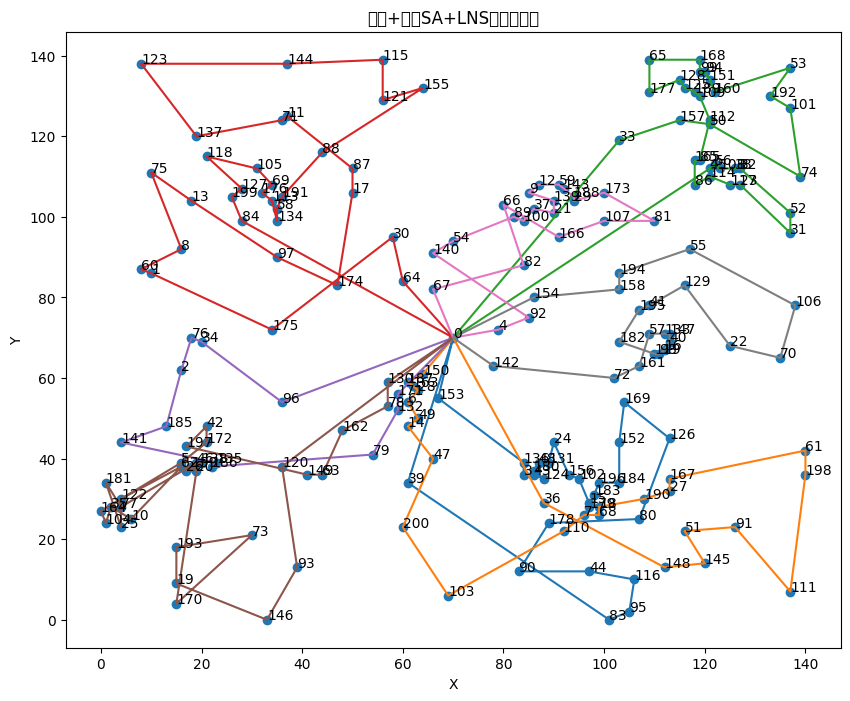

In [28]:
import pandas as pd
import numpy as np
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ------ 参数配置 ------
EXCEL_PATH = r"C:\Users\Administrator\Desktop\RC2_2_10.xlsx"
CAPACITY = 1000
GLOBAL_TIME_LIMIT = 180  # 秒
CLUSTER_COUNT = 5
# SA 参数
SA_INITIAL_TEMP = 1000
SA_INTERVAL = 500
SA_THRESHOLD = 0.1
# 2-opt 限制尝试
TWO_OPT_TRIALS = 300
# LNS 参数
LNS_REMOVE_COUNT = 5

# ------ 读取数据 ------
df = pd.read_excel(EXCEL_PATH)
nodes = df['id'].tolist()
coords = df[['x_coord', 'y_coord']].values
demand = dict(zip(nodes, df['demand']))
ready = dict(zip(nodes, df['et']))
due   = dict(zip(nodes, df['lt']))
service = dict(zip(nodes, df['st']))

# ------ 聚类 ------
non_depot = nodes[1:]
non_coords = coords[1:]
km = KMeans(n_clusters=CLUSTER_COUNT, random_state=0).fit(non_coords)
labels = km.labels_
clusters = {i: [] for i in range(CLUSTER_COUNT)}
for node, lab in zip(non_depot, labels):
    clusters[lab].append(node)

# ------ 子问题构建 ------
def build_problem(sub_nodes):
    sub = [nodes[0]] + sub_nodes
    idx = {n: i for i, n in enumerate(sub)}
    sub_coords = np.array([coords[nodes.index(n)] for n in sub])
    # 距离矩阵
    m = len(sub)
    d = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            d[i,j] = math.hypot(*(sub_coords[i] - sub_coords[j]))
    sub_demand = {n: demand[n] for n in sub}
    sub_ready  = {n: ready[n] for n in sub}
    sub_due    = {n: due[n] for n in sub}
    sub_srv    = {n: service[n] for n in sub}
    return sub, d, sub_demand, sub_ready, sub_due, sub_srv

# ------ 路径成本 ------
def cost_route(route, sub, d, sd, sr, sl, ss):
    c = 0; t = 0; load = 0; prev=0
    for n in route:
        i = sub.index(n)
        c += d[prev,i]
        t = max(t + d[prev,i], sr[n]) + ss[n]
        if t > sl[n] or load + sd[n] > CAPACITY:
            return float('inf'), float('inf')
        load += sd[n]; prev = i
    c += d[prev,0]
    return c, t

# ------ 总成本 ------
def cost_total(sol, *args):
    return sum(cost_route(r, *args)[0] for r in sol)

# ------ 贪心初始解 ------
def greedy_init(sub, d, sd, sr, sl, ss):
    un = set(sub[1:]); sol=[]
    while un:
        route=[]; load=0; t=0; prev=0
        for n in sorted(un, key=lambda x: sr[x]):
            if load+sd[n] <= CAPACITY:
                i=sub.index(n)
                arr = max(t+d[prev,i], sr[n])
                if arr+ss[n] <= sl[n]:
                    route.append(n); load+=sd[n]; t=arr+ss[n]; prev=i
        sol.append(route)
        un -= set(route)
    return sol

# ------ 限制式 2-opt ------
def limited_two_opt(route, sub, d, sd, sr, sl, ss, tb):
    st=time.time(); best=route[:]; bc=cost_route(best, sub, d, sd, sr, sl, ss)[0]
    for _ in range(TWO_OPT_TRIALS):
        if time.time()-st > tb: break
        i,j=sorted(random.sample(range(1,len(best)),2))
        if j-i<2: continue
        cand=best[:]; cand[i:j]=reversed(cand[i:j])
        cc=cost_route(cand, sub, d, sd, sr, sl, ss)[0]
        if cc<bc: best,bc=cand,cc
    return best

# ------ LNS 大邻域搜索 ------
def lns(sol, sub, d, sd, sr, sl, ss, tb):
    st=time.time(); best=sol; best_cost=cost_total(sol, sub,d,sd,sr,sl,ss)
    while time.time()-st<tb:
        # 破坏：随机移除节点
        rem=[]; new_sol=[r[:] for r in best]
        for _ in range(LNS_REMOVE_COUNT):
            rir=random.choice(range(len(new_sol)))
            if new_sol[rir]: rem.append(new_sol[rir].pop(random.randrange(len(new_sol[rir]))))
        # 修复：贪心插入
        for n in rem:
            best_pos=(None,None, float('inf'))
            for ri in range(len(new_sol)):
                for pos in range(len(new_sol[ri])+1):
                    tmp=new_sol[ri][:]
                    tmp.insert(pos,n)
                    c,_=cost_route(tmp, sub,d,sd,sr,sl,ss)
                    if c<best_pos[2]: best_pos=(ri,pos,c)
            if best_pos[0] is None:
                new_sol.append([n])
            else:
                new_sol[best_pos[0]].insert(best_pos[1],n)
        new_cost=cost_total(new_sol, sub,d,sd,sr,sl,ss)
        if new_cost<best_cost:
            best, best_cost = new_sol, new_cost
    return best, best_cost

# ------ 混合 SA + LNS 求解子问题 ------
def solve_subproblem(sub_nodes, time_limit):
    sub, d, sd, sr, sl, ss = build_problem(sub_nodes)
    sol = greedy_init(sub, d, sd, sr, sl, ss)
    # 模拟退火
    best, bc = sol, cost_total(sol,sub,d,sd,sr,sl,ss)
    curr, cc = best, bc
    T0=SA_INITIAL_TEMP; st=time.time(); it=0
    while time.time()-st<time_limit*0.6:
        T=T0*(1-(time.time()-st)/(time_limit*0.6))
        ns=[r[:] for r in curr]
        if len(ns)>1:
            r1,r2=random.sample(range(len(ns)),2)
            if ns[r1]:
                n=ns[r1].pop(random.randrange(len(ns[r1])));
                ns[r2].insert(random.randrange(len(ns[r2])+1),n)
                ns=[r for r in ns if r]
                nc=cost_total(ns,sub,d,sd,sr,sl,ss)
                delta=nc-cc
                if delta<0 or random.random()<math.exp(-delta/max(T,1e-8)):
                    curr,cc=ns,nc
                    if nc<bc:
                        best,bc=[r[:] for r in curr],nc
                        # 限定2-opt
                        rem_time=time_limit*0.6-(time.time()-st)
                        if it%SA_INTERVAL==0 and T<T0*SA_THRESHOLD and rem_time>1:
                            worst=max(range(len(curr)),key=lambda i:cost_route(curr[i],sub,d,sd,sr,sl,ss)[0])
                            curr[worst]=limited_two_opt(curr[worst],sub,d,sd,sr,sl,ss,rem_time*0.5)
                            cc=cost_total(curr,sub,d,sd,sr,sl,ss)
                            if cc<bc: best,bc=[r[:] for r in curr],cc
        it+=1
    # LNS 强化
    rem_time=time_limit - (time.time()-st)
    if rem_time>1:
        best,bc=lns(best,sub,d,sd,sr,sl,ss,rem_time)
    return best,bc

def validate_solution(routes):
    visited = set()
    feasible = True
    for idx, route in enumerate(routes, 1):
        load = 0; t = 0; prev = nodes[0]
        for n in route:
            if n in visited:
                print(f"节点 {n} 在车辆 {idx} 重复访问！")
                feasible = False
            visited.add(n)
            load += demand[n]
            if load > CAPACITY:
                print(f"车辆 {idx} 超载：{load} > {CAPACITY}")
                feasible = False
            dist = math.hypot(*(coords[nodes.index(prev)] - coords[nodes.index(n)]))
            t = max(t + dist, ready[n]) + service[n]
            if t > due[n]:
                print(f"车辆 {idx} 在节点 {n} 违反时窗：到达 {t}, 最迟 {due[n]}")
                feasible = False
            prev = n
        # 回仓库检测
        dist_back = math.hypot(*(coords[nodes.index(prev)] - coords[0]))
        t += dist_back
    # 检测所有节点覆盖
    missing = set(nodes[1:]) - visited
    if missing:
        print(f"未访问节点：{sorted(missing)}")
        feasible = False
    if feasible:
        print("解经验证：所有约束均满足，解可行。")

# ------ 主流程 ------
all_routes=[]; total_dist=0
per_time=GLOBAL_TIME_LIMIT/CLUSTER_COUNT
for i in range(CLUSTER_COUNT):
    sol,dist_i=solve_subproblem(clusters[i], per_time)
    all_routes+=sol; total_dist+=dist_i

# 验证解的可行性
validate_solution(all_routes)

print(f"聚类数：{CLUSTER_COUNT}, 总距离：{total_dist}")
for i,r in enumerate(all_routes,1): print(f"车{i}: 0 -> {' -> '.join(map(str,r))} -> 0")

# 可视化
plt.figure(figsize=(10,8)); plt.scatter(coords[:,0],coords[:,1])
for idx,n in enumerate(nodes): plt.annotate(n,(coords[idx,0],coords[idx,1]))
for r in all_routes:
    xs=[coords[0,0]]+[coords[nodes.index(x),0] for x in r]+[coords[0,0]]
    ys=[coords[0,1]]+[coords[nodes.index(x),1] for x in r]+[coords[0,1]]
    plt.plot(xs,ys)
plt.title("分簇+混合SA+LNS路径可视化"); plt.xlabel("X"); plt.ylabel("Y"); plt.show()
